<a href="https://colab.research.google.com/github/Hidekithiago/Projetos/blob/main/Bike_store_sales_in_Europe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bike-sales-in-europe:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F889310%2F1509564%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240313%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240313T133607Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7e4baa4d7a448ce7e2cee5c7b1c996bad36c34e17568ec9da9a2fa33b6631bc1cbdb28ec9d144ee4dae5e9cc307a9d5e9a5769c8974f9e7bf99cf071df9b5ce2ae4a43740c74b4682b21c3d9b4565aa1a9d9bf0ccdc7fc91b9852d89fd88381ff90da4b04fe356f290382cda42f7396e99f91b8ecc7a40f427467e085b53a373df4ac9fdac4c38793c0dabb494aabfbb8429fe48e75490724f081e6bd4b06937da3b3a6316936a0665e5d5e88813af038c4227c964d7f67d01ffc9f5e148f098dca73d6c4807a238d4214631b6c520ba2cd2b3907a571f50d8a1bf55abcceeab500e4d12715119422ca78a08e8b5c97ccb89058db3cbe64e5ddb46e387179e1b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1209546 bytes downloaded
Downloaded and uncompressed: bike-sales-in-europe
Data source import complete.


### Bike store sales DataSet

<img src="https://user-images.githubusercontent.com/7065401/58563302-42466a80-8201-11e9-9948-b3e9f88a5662.jpg"
    style="width:400px; float: right; margin: 0 30px 30px 30px;"></img>
**Analyzing sales made on bike stores**


**DataSet**  :   [Bike Store Sales](https://docs.google.com/spreadsheets/d/1NOe_UrPx6ULF2C5MvHmZ9ODuw8t9M77Q1Y64gP-7JHA/edit?usp=sharing)


## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



### Load Data

In [3]:
Sales=pd.read_csv('/kaggle/input/bike-sales-in-europe/Sales.csv')

In [4]:
Sales.head()

,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,2013-11-26,26,November,2013,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
1,2015-11-26,26,November,2015,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
2,2014-03-23,23,March,2014,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,23,45,120,1366,1035,2401
3,2016-03-23,23,March,2016,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,20,45,120,1188,900,2088
4,2014-05-15,15,May,2014,47,Adults (35-64),F,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,4,45,120,238,180,418


### Rows & Columns

In [5]:
Sales['Country'].unique()

array(['Canada', 'Australia', 'United States', 'Germany', 'France',
       'United Kingdom'], dtype=object)

In [6]:
Shape = Sales.shape
Rows=Shape[0]
Col= Shape[1]
print(f"Rows of DataSet is :  {Rows}")
print(f"Columns of DataSet is :  {Col}")

Rows of DataSet is :  113036
Columns of DataSet is :  18


# Data Preprocessing
-------------------------------------------
### **Identify Type of Columns**





In [7]:
Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113036 entries, 0 to 113035
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Date              113036 non-null  object
 1   Day               113036 non-null  int64 
 2   Month             113036 non-null  object
 3   Year              113036 non-null  int64 
 4   Customer_Age      113036 non-null  int64 
 5   Age_Group         113036 non-null  object
 6   Customer_Gender   113036 non-null  object
 7   Country           113036 non-null  object
 8   State             113036 non-null  object
 9   Product_Category  113036 non-null  object
 10  Sub_Category      113036 non-null  object
 11  Product           113036 non-null  object
 12  Order_Quantity    113036 non-null  int64 
 13  Unit_Cost         113036 non-null  int64 
 14  Unit_Price        113036 non-null  int64 
 15  Profit            113036 non-null  int64 
 16  Cost              113036 non-null  int

### Convert date

> **Convert Object into dateTime Category**

In [8]:
Sales['Date'] = pd.to_datetime(Sales['Date'])

### Change the Date Format

In [9]:
Sales["Calculated_Date"]= Sales[['Year', 'Month', 'Day']].apply(lambda x: '{}-{}-{}'.format(x[0], x[1], x[2]), axis=1)
Sales["Calculated_Date"]=pd.to_datetime(Sales['Calculated_Date'])
Sales["Calculated_Date"].head()


0   2013-11-26
1   2015-11-26
2   2014-03-23
3   2016-03-23
4   2014-05-15
Name: Calculated_Date, dtype: datetime64[ns]

### **Identify Null And Missing Values**

In [10]:
Sales.isnull().sum()

Date                0
Day                 0
Month               0
Year                0
Customer_Age        0
Age_Group           0
Customer_Gender     0
Country             0
State               0
Product_Category    0
Sub_Category        0
Product             0
Order_Quantity      0
Unit_Cost           0
Unit_Price          0
Profit              0
Cost                0
Revenue             0
Calculated_Date     0
dtype: int64

In [11]:
Sales.describe()

,Day,Year,Customer_Age,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
count,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000
mean,15.665753,2014.401739,35.919212,11.901660,267.296366,452.938427,285.051665,469.318695,754.370360
std,8.781567,1.272510,11.021936,9.561857,549.835483,922.071219,453.887443,884.866118,1309.094674
min,1.000000,2011.000000,17.000000,1.000000,1.000000,2.000000,-30.000000,1.000000,2.000000
25%,8.000000,2013.000000,28.000000,2.000000,2.000000,5.000000,29.000000,28.000000,63.000000
50%,16.000000,2014.000000,35.000000,10.000000,9.000000,24.000000,101.000000,108.000000,223.000000
75%,23.000000,2016.000000,43.000000,20.000000,42.000000,70.000000,358.000000,432.000000,800.000000
max,31.000000,2016.000000,87.000000,32.000000,2171.000000,3578.000000,15096.000000,42978.000000,58074.000000


> ## Numerical analysis and visualization
_We'll analyze the Numerical features column:_

In [12]:
Sales['Unit_Cost'].describe()


count    113036.000000
mean        267.296366
std         549.835483
min           1.000000
25%           2.000000
50%           9.000000
75%          42.000000
max        2171.000000
Name: Unit_Cost, dtype: float64

In [13]:
Sales['Unit_Cost'].mean()

267.296365759581

In [14]:
Sales['Unit_Cost'].median()

9.0

<Axes: >

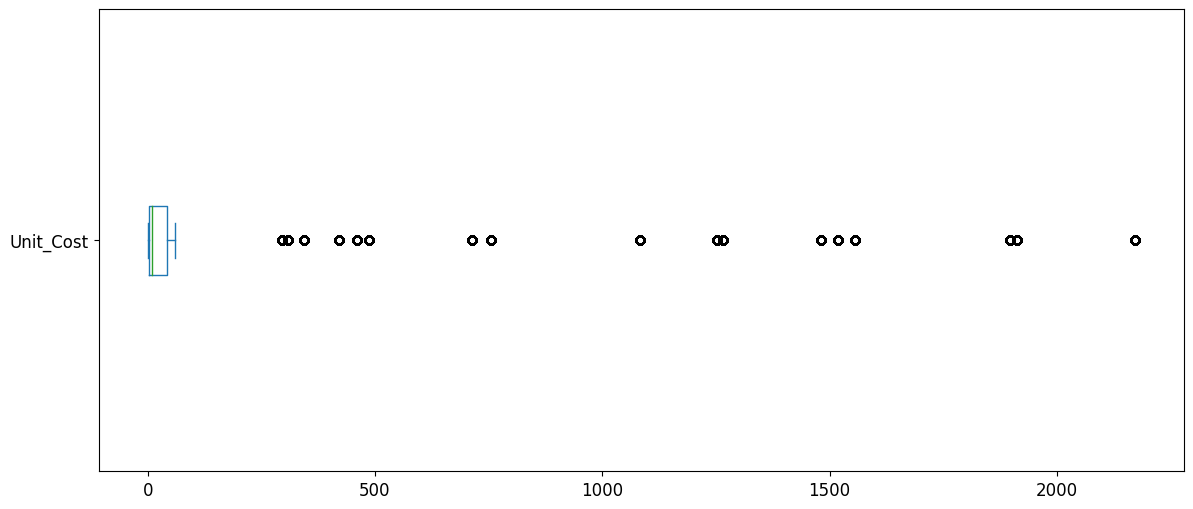

In [15]:
Sales['Unit_Cost'].plot(kind="box",figsize=(14,6),vert=False, fontsize=12)

Text(0, 0.5, 'Sales')

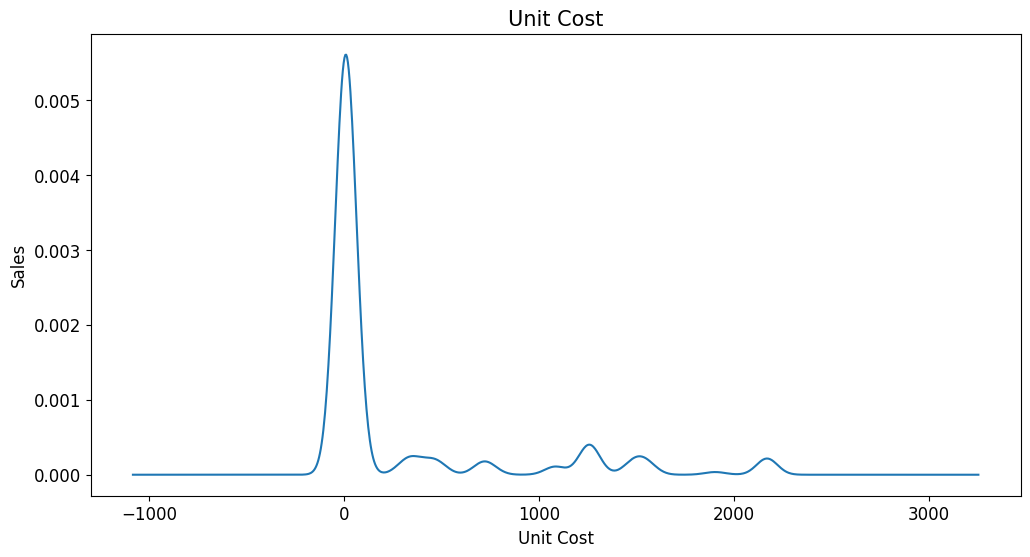

In [16]:
Sales['Unit_Cost'].plot(kind="density" , figsize=(12,6), fontsize=12)
plt.title("Unit Cost",fontsize=15)
plt.xlabel("Unit Cost",fontsize=12)
plt.ylabel("Sales",fontsize=12)


### Median and Mean at Unit Cost

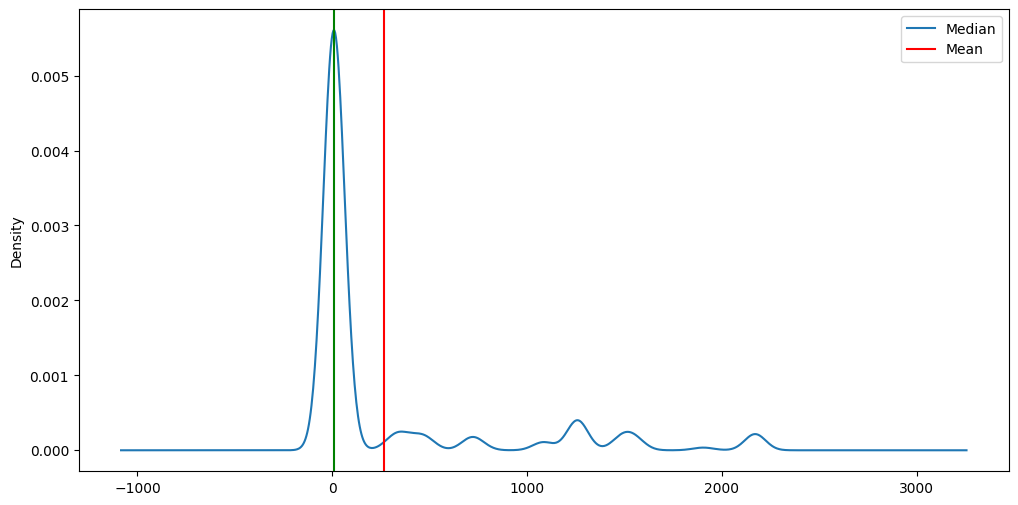

In [17]:
ax=Sales['Unit_Cost'].plot(kind="density" , figsize=(12,6))
# ax.axvlines(Sales['Unit_Cost'].mean())
mean= ax.axvline(Sales['Unit_Cost'].mean(), color='red' )
median = ax.axvline(Sales['Unit_Cost'].median(), color='g')
plt.legend({'Median':median,'Mean':mean})

Text(0.5, 0, 'Dollars')

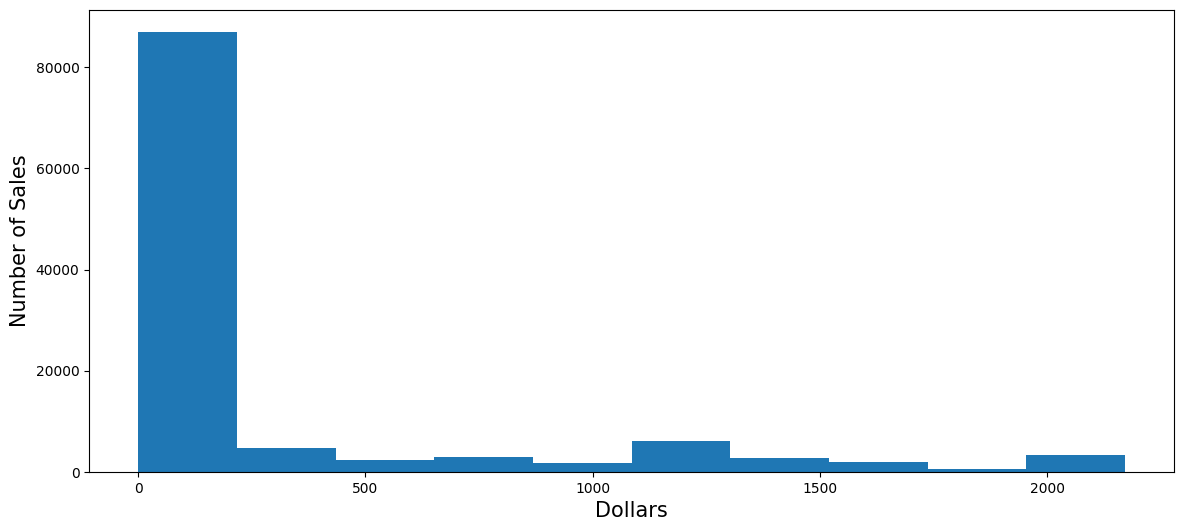

In [18]:
ax = Sales['Unit_Cost'].plot(kind='hist', figsize=(14,6))
ax.set_ylabel('Number of Sales', fontsize=15)
ax.set_xlabel('Dollars', fontsize=15)

### Mean of Customers Age

In [19]:
Sales["Customer_Age"].value_counts().mean()

1614.8

<Axes: >

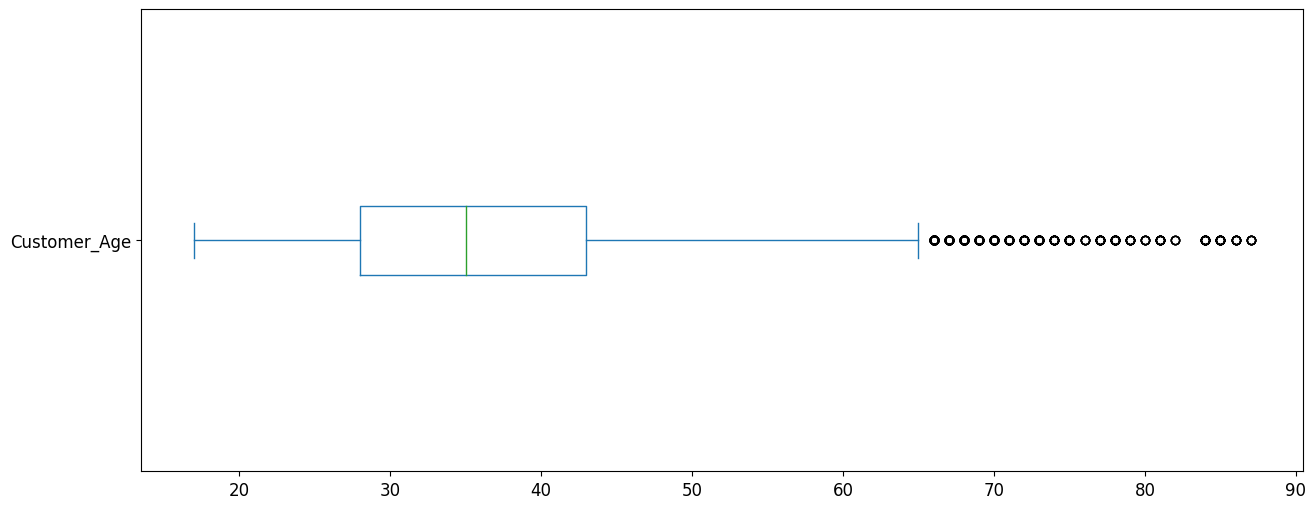

In [20]:
Sales["Customer_Age"].plot(kind='box',vert=False,figsize=(15,6), fontsize=12)

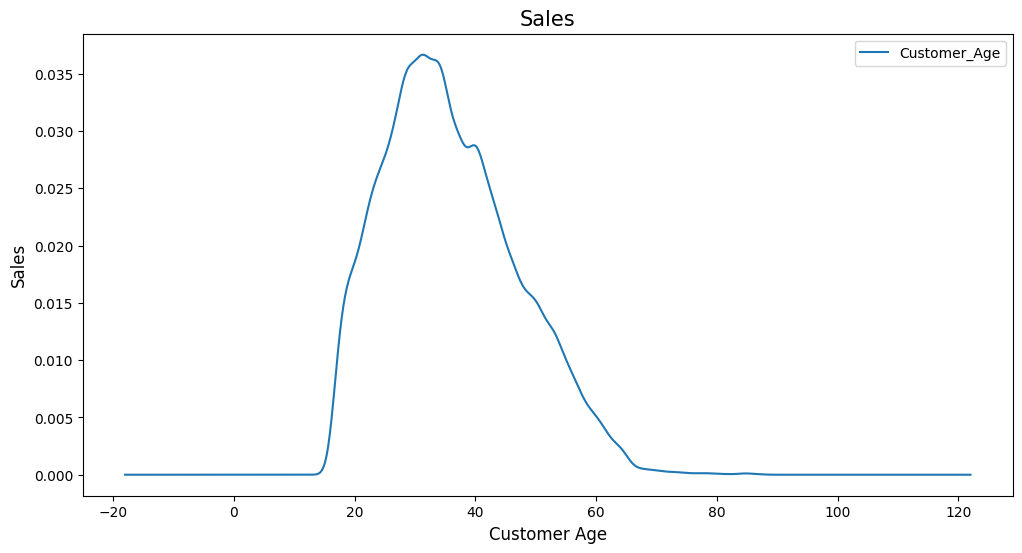

In [21]:
Sales["Customer_Age"].plot(kind='kde',figsize=(12,6))
plt.title("Sales",fontsize=15)
plt.xlabel("Customer Age",fontsize=12)
plt.ylabel("Sales",fontsize=12)
plt.legend()

### Sales According to years

In [22]:
Sales['Year'].value_counts()

2014    29398
2016    29398
2013    24443
2015    24443
2012     2677
2011     2677
Name: Year, dtype: int64

<Axes: >

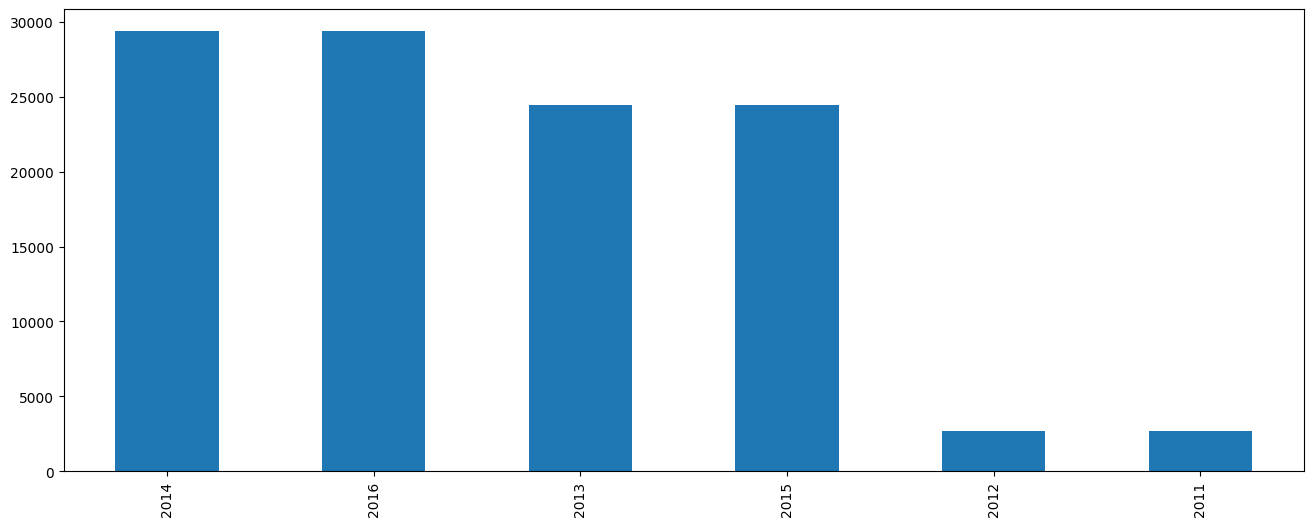

In [23]:
Sales["Year"].value_counts().plot(kind="bar",figsize=(16,6))

### Sales According to Month

In [24]:
Sales['Month'].value_counts()

June         11234
December     11200
May          11128
April        10182
March         9674
January       9284
February      9022
October       8750
November      8734
August        8200
September     8166
July          7462
Name: Month, dtype: int64

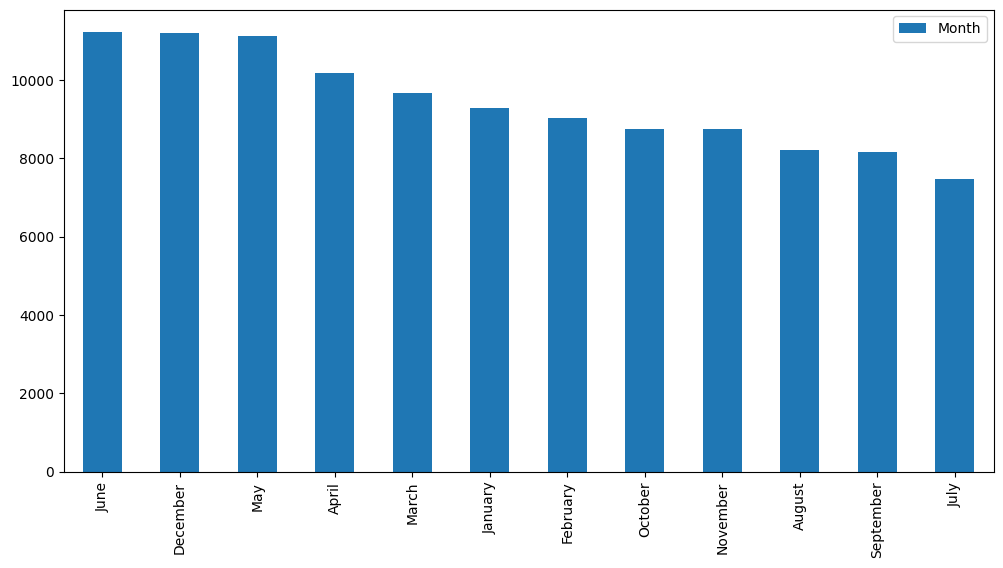

In [25]:
Sales["Month"].value_counts().plot(kind="bar",figsize=(12,6))
plt.legend()

> ### Sales evolve through the years

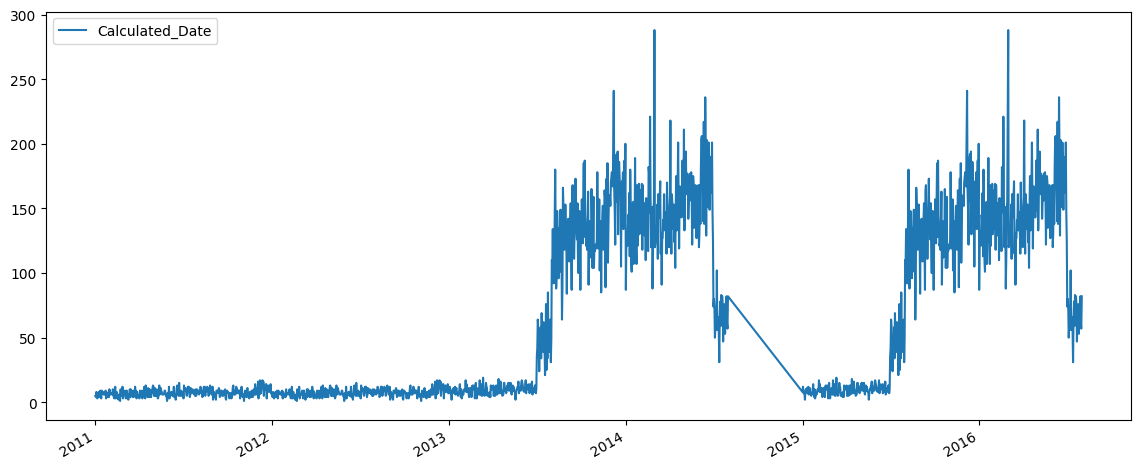

In [26]:
Sales['Calculated_Date'].value_counts().plot(kind="line",figsize=(14,6))
plt.legend()

### Increase 50 Udollar'S revenue to every sale

In [27]:
Sales['Revenue']+50

0         1000
1         1000
2         2451
3         2138
4          468
          ... 
113031     234
113032    1233
113033    1233
113034    1310
113035    1257
Name: Revenue, Length: 113036, dtype: int64

> ## Categorical Analysis and visualization
_We'll analyze the categorical features column_

> ### Sales According to Age Group

In [28]:
Sales['Age_Group'].value_counts()

Adults (35-64)          55824
Young Adults (25-34)    38654
Youth (<25)             17828
Seniors (64+)             730
Name: Age_Group, dtype: int64

Text(0.5, 0, 'Age')

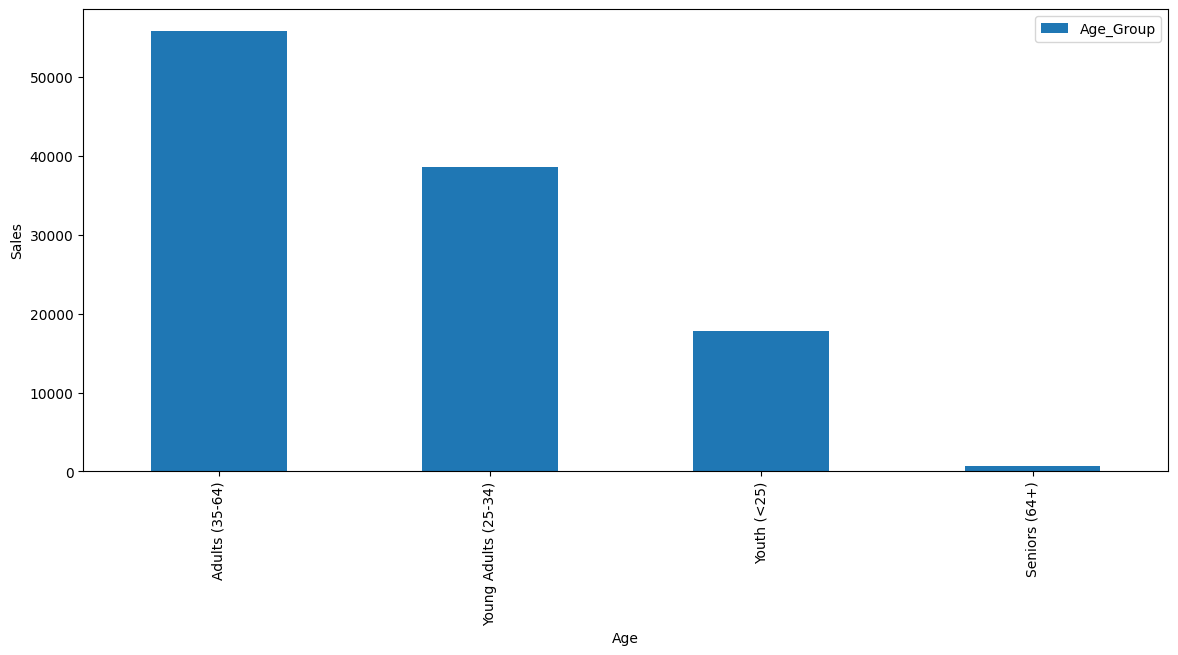

In [29]:
Sales["Age_Group"].value_counts().plot(kind='bar',figsize=(14,6))
plt.legend()
plt.legend()
plt.ylabel("Sales")
plt.xlabel("Age")

Text(0.5, 1.0, 'Age Group')

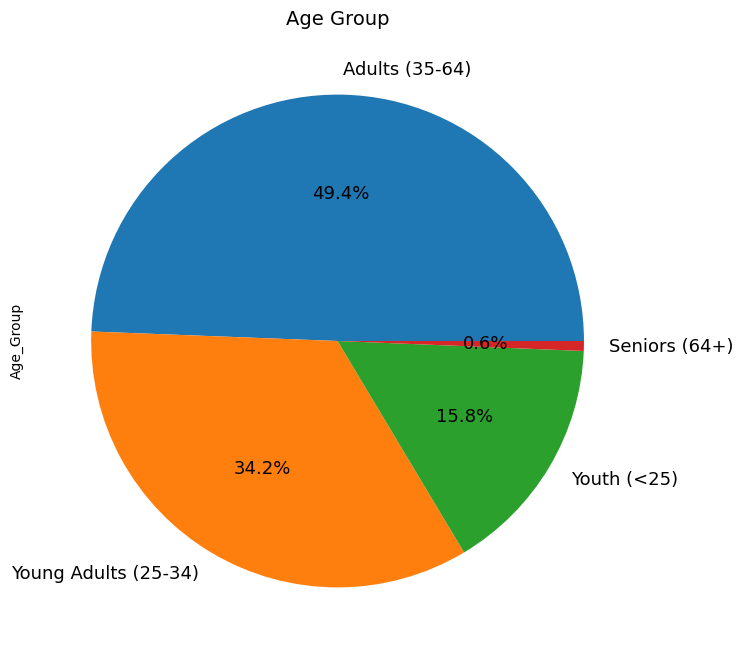

In [30]:
Sales["Age_Group"].value_counts().plot(kind='pie',figsize=(14,8),autopct='%1.1f%%',fontsize=13)
plt.title("Age Group",fontsize=14)

### Mean of Sales order

In [31]:
Sales["Order_Quantity"].mean()

11.901659648253654

Text(0.5, 1.0, 'Order Quality')

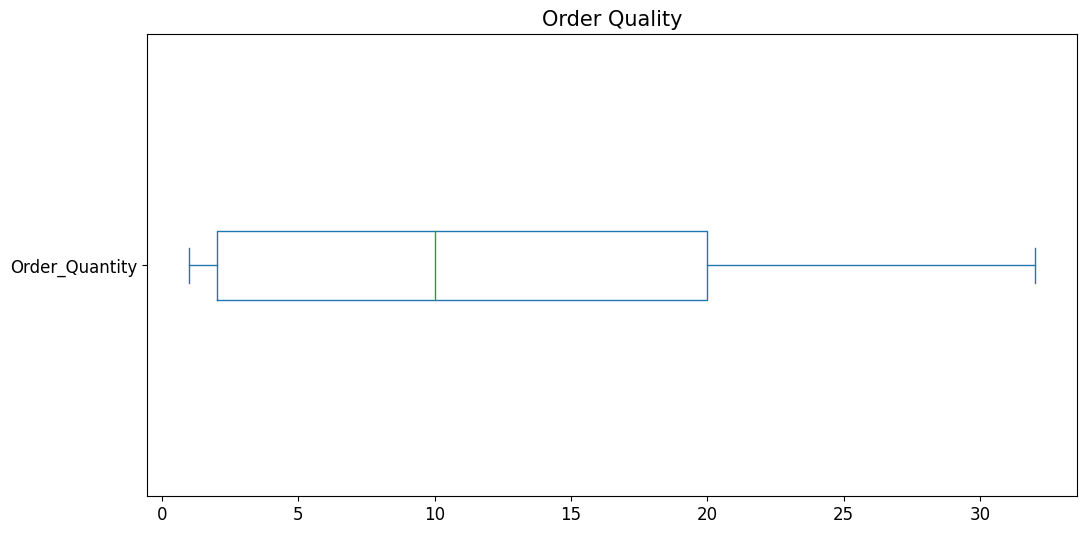

In [32]:
Sales["Order_Quantity"].plot(kind='box',vert=False,figsize=(12,6),fontsize=12)
plt.title("Order Quality",fontsize=15)


> ### Sales According to Country

In [33]:
Sales['Country'].value_counts()

United States     39206
Australia         23936
Canada            14178
United Kingdom    13620
Germany           11098
France            10998
Name: Country, dtype: int64

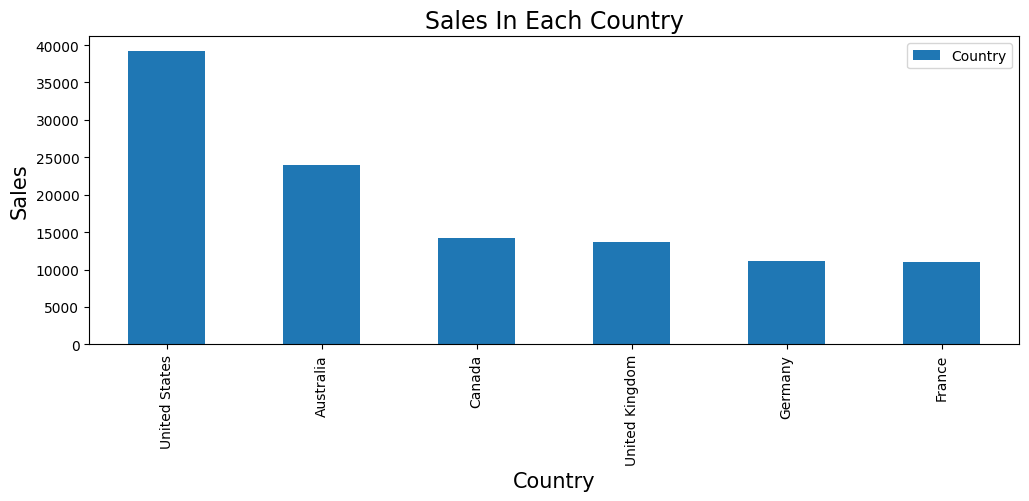

In [34]:
Sales['Country'].value_counts().plot(kind='bar',figsize=(12,4))
plt.title("Sales In Each Country",fontsize=17)
plt.ylabel("Sales",fontsize=15)
plt.xlabel("Country",fontsize=15)
plt.legend()

> ### List of every product sold

In [35]:
MostSales=Sales.loc[: ,"Product"].unique()
# sales['Product'].unique()

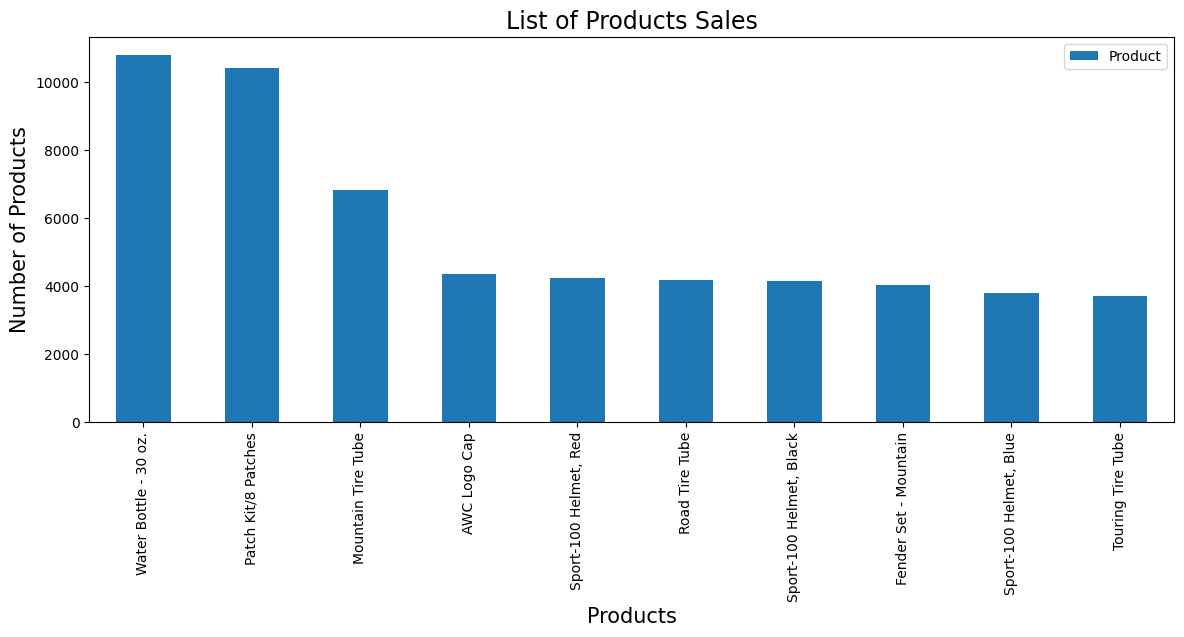

In [36]:
Sales.loc[: ,"Product"].value_counts().head(10).plot(kind='bar',figsize=(14,5))
plt.title("List of Products Sales",fontsize=17)
plt.ylabel("Number of Products",fontsize=15)
plt.xlabel("Products",fontsize=15)
plt.legend()

> ### Relation between Unit cost & Unit Price

Text(0.5, 0, 'Unit Cost')

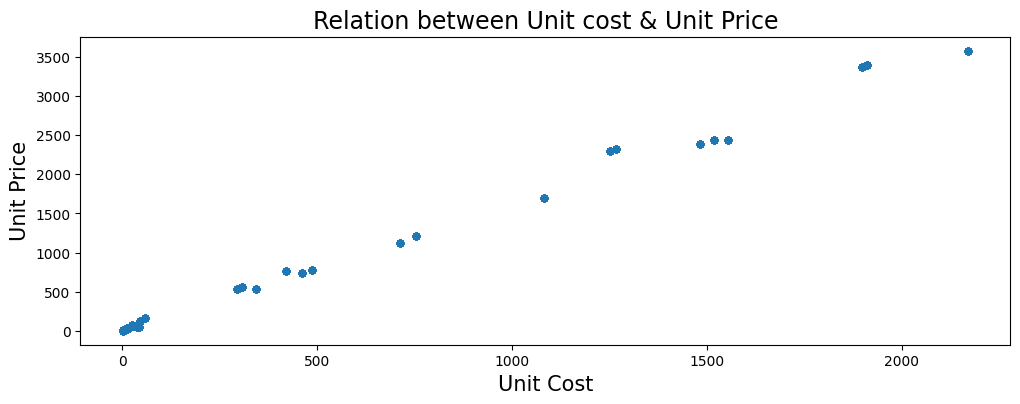

In [37]:
Sales.plot(kind='scatter',x="Unit_Cost", y="Unit_Price",figsize=(12,4),fontsize=10)
plt.title("Relation between Unit cost & Unit Price",fontsize=17)
plt.ylabel("Unit Price",fontsize=15)
plt.xlabel("Unit Cost",fontsize=15)


> ### Relation between Order Quantitity & Profit

Text(0.5, 1.0, 'Relation Between Order Quantity & Profit')

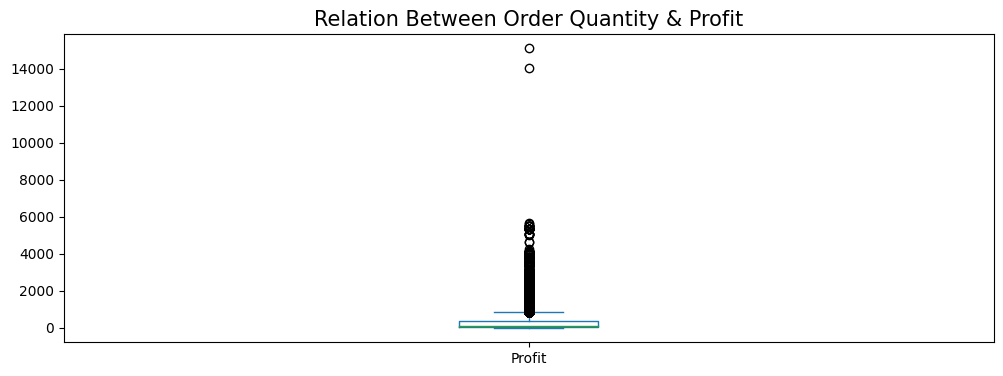

In [38]:
Sales.plot(kind="box",x='Order_Quantity',y='Profit',figsize=(12,4),fontsize=10)
plt.title("Relation Between Order Quantity & Profit",fontsize=15)


> ### Relation between Country & Unit Profit

Text(0.5, 1.0, 'Relation between Country & Unit Profit')

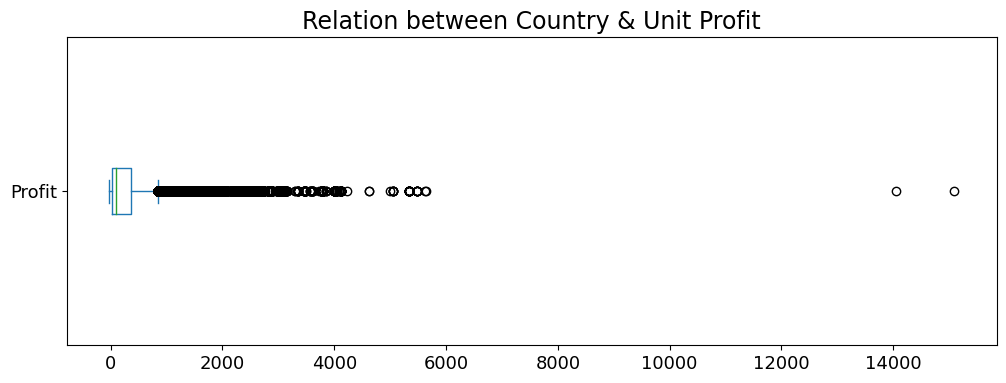

In [39]:
Sales.plot(kind="box",x='Country',y='Profit',figsize=(12,4),fontsize=13,vert=False )
plt.title("Relation between Country & Unit Profit",fontsize=17)


> ### Customer Age According to Country

<Axes: title={'center': 'Customer_Age'}, xlabel='[Country]'>

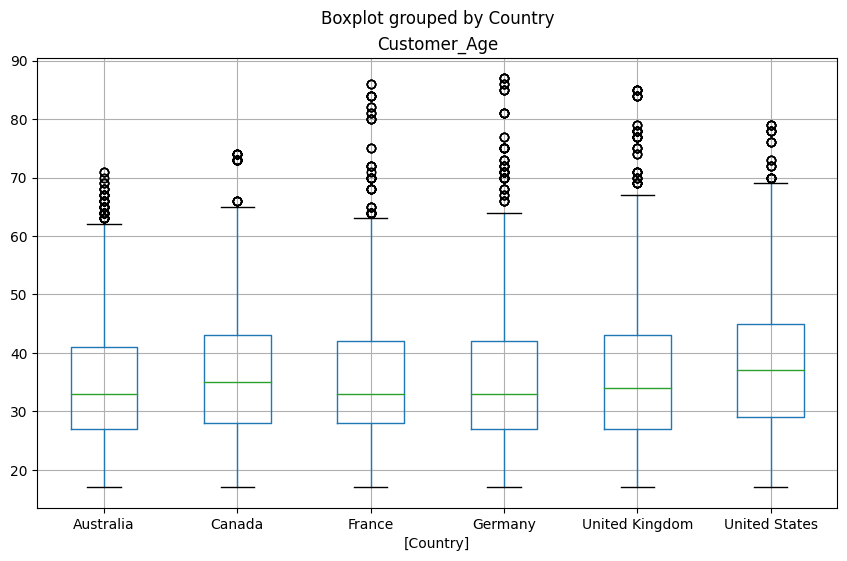

In [40]:
Sales[["Customer_Age","Country"]].boxplot(by='Country',figsize=(10,6))

 > ### How many orders were made in Canada or France?

In [41]:
Sales.loc[((Sales['Country']=='Canada' ) |  (Sales['Country']=='France' ))].shape[0]

25176

 > ### How many Bike Racks orders were made from Canada?

In [42]:
Sales.loc[(Sales['Country']=='Canada' ) & (Sales['Sub_Category']=="Bike Racks")].shape[0]

104

> ### Sales in Each State of France

In [43]:
Sales.loc[Sales["Country"]=="France","State"].value_counts()

Seine (Paris)        2328
Seine Saint Denis    1684
Nord                 1670
Hauts de Seine       1084
Essonne               994
Yveline               954
Seine et Marne        394
Moselle               386
Loiret                382
Val d'Oise            264
Garonne (Haute)       208
Val de Marne          158
Charente-Maritime     148
Somme                 134
Loir et Cher          120
Pas de Calais          90
Name: State, dtype: int64

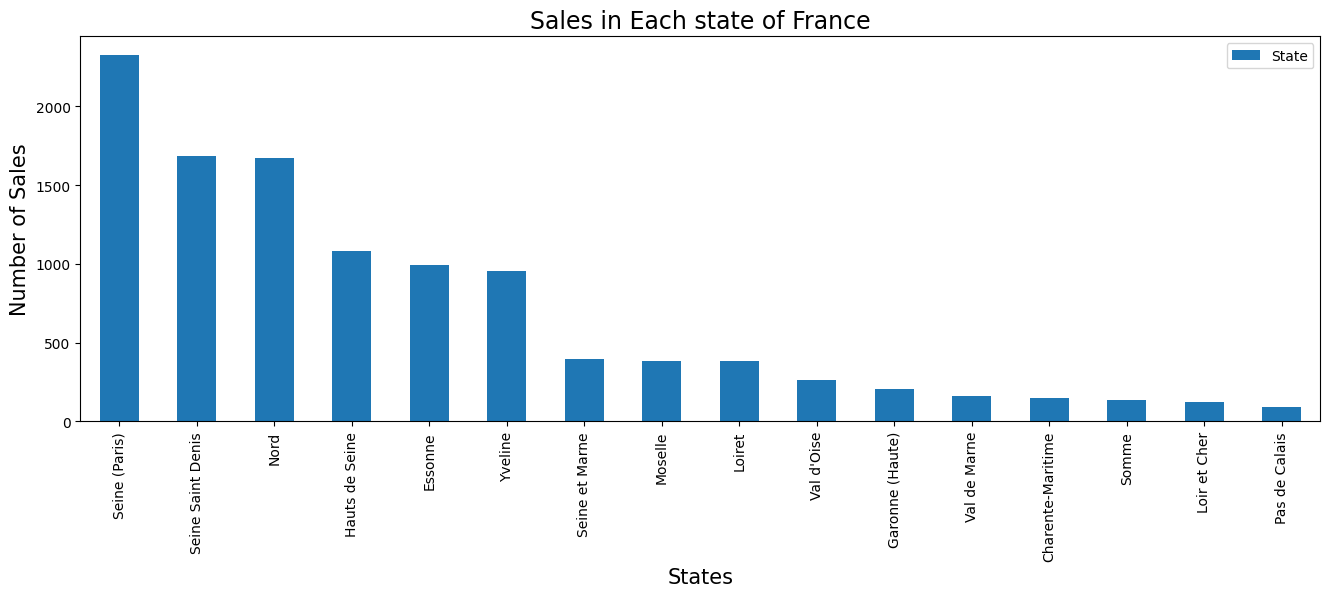

In [44]:
Sales.loc[Sales["Country"]=="France","State"].value_counts().plot(kind='bar',figsize=(16,5))
plt.title("Sales in Each state of France",fontsize=17)
plt.ylabel("Number of Sales",fontsize=15)
plt.xlabel("States",fontsize=15)
plt.legend()

plt.legend()

### How many sales were made per category?

In [45]:
Sales['Sub_Category'].value_counts()

Tires and Tubes      33870
Bottles and Cages    15876
Road Bikes           13430
Helmets              12158
Mountain Bikes        8854
Jerseys               6010
Caps                  4358
Fenders               4032
Touring Bikes         3698
Gloves                2686
Cleaners              1802
Shorts                1794
Hydration Packs       1334
Socks                 1122
Vests                  964
Bike Racks             592
Bike Stands            456
Name: Sub_Category, dtype: int64

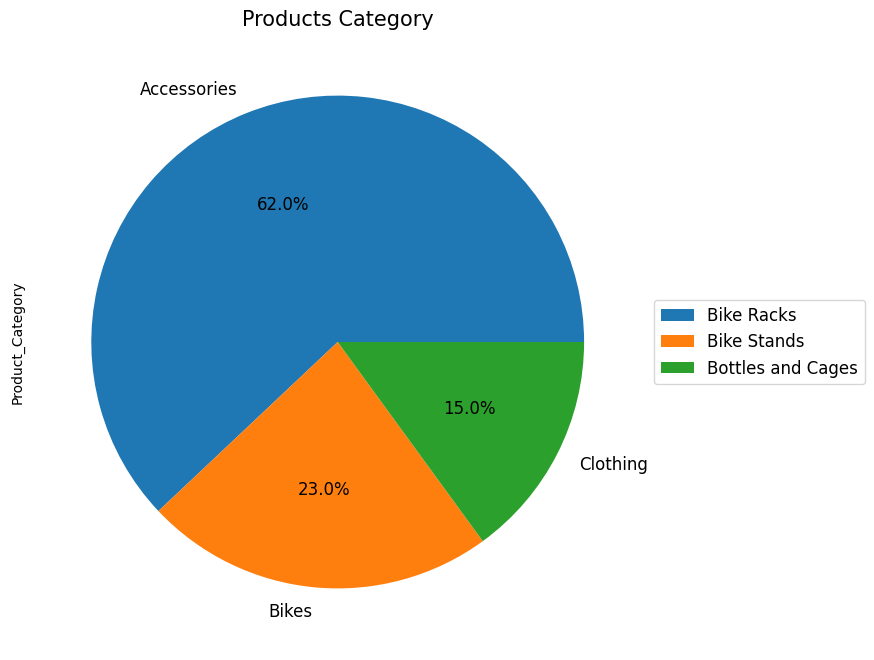

In [47]:
Sales['Product_Category'].value_counts().plot(kind='pie',figsize=(8,8),autopct='%1.1f%%',fontsize=12)
Cat=Sales['Sub_Category'].unique()
plt.title("Products Category",fontsize=15)
plt.legend(Cat,fontsize=12,loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))



In [48]:
Sales["Sub_Category"].value_counts()

Tires and Tubes      33870
Bottles and Cages    15876
Road Bikes           13430
Helmets              12158
Mountain Bikes        8854
Jerseys               6010
Caps                  4358
Fenders               4032
Touring Bikes         3698
Gloves                2686
Cleaners              1802
Shorts                1794
Hydration Packs       1334
Socks                 1122
Vests                  964
Bike Racks             592
Bike Stands            456
Name: Sub_Category, dtype: int64

In [ ]:
Sales.loc[Sales['Product_Category']=='Accessories' ,"Sub_Category"].value_counts()

In [ ]:
Sales.loc[Sales['Product_Category']=='Accessories' ,"Sub_Category"].value_counts().plot(kind="bar",figsize=(16,4))
plt.legend()

In [ ]:
Sales.loc[Sales['Product_Category']=="Bikes","Sub_Category"].value_counts()

In [ ]:
Pc=Sales.loc[Sales['Product_Category']=="Bikes","Sub_Category"].unique()
Sales.loc[Sales['Product_Category']=="Bikes","Sub_Category"].value_counts().plot(kind="pie",figsize=(8,8),fontsize=12)
plt.legend(fontsize=13,loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("Products Category in Bikes",fontsize=15)



### Which gender has the most amount of sales?

In [ ]:
Sales['Customer_Gender'].value_counts()

In [ ]:
Sales['Customer_Gender'].value_counts().plot(kind='bar',fontsize=12,figsize=(8,6))
plt.ylabel("Sales",fontsize=13)


### How many sales with more than 500 in Revenue were made by men?

In [ ]:
Sales.loc[(Sales['Customer_Gender']=="M") & (Sales["Revenue"]>=500)].shape[0]

### Get the top-5 sales with the highest revenue

In [ ]:
Sales.sort_values(['Revenue'],ascending=False).head(5)

### Get the sale with the highest revenue

In [ ]:
# Sales.sort_values(['Revenue'],ascending=False).head(1)

Sales['Revenue'].max()

# Cond=Sales['Revenue']==Sales["Revenue"].max()
# Sales.loc[Cond]

### What is the mean Order_Quantity of orders with more than 10K in revenue?

In [ ]:

Sales.loc[Sales["Revenue"]>10_000 , "Order_Quantity"].mean()

# cond = Sales['Revenue'] > 10_000
# Sales.loc[cond, 'Order_Quantity'].mean()


### What is the mean Order_Quantity of orders with less than 10K in revenue?

In [ ]:
Sales.loc[Sales["Revenue"]<10_000,"Order_Quantity"].mean()

### How many orders were made in May of 2016?

In [ ]:
Sales.loc[(Sales["Year"]==2016) & (Sales["Month"]=='May')].shape[0]

### How many orders were made in May,June,July of 2016?

In [ ]:
Sales.loc[(Sales['Year'] == 2016) & (Sales['Month'].isin(['May', 'June', 'July']))].shape[0]

In [ ]:
Saels2016=Sales.loc[Sales["Year"]==2016 , ['Profit',"Month"]]
Saels2016.boxplot(by="Month", figsize=(14,6))

### 10% tax on Sales in USA

In [ ]:
Sales.loc[Sales["Country"]=="United State",'Unit_Price']*=1.072

In [ ]:
Sales["Unit_Price"].head(2)

### Customer Revenue  according to age

In [ ]:
plt.figure(figsize=(16,8))
Sales.plot(kind="scatter",x="Customer_Age",y="Revenue",figsize=(10,8),fontsize=12)
plt.xlabel("Customer Age",fontsize=13)
plt.ylabel("Revenue",fontsize=13)
plt.show()

### Customer Revenue with profit

In [ ]:
Sales.plot(kind='scatter', x='Revenue', y='Profit', figsize=(10,8),fontsize=12)
plt.xlabel("Revenue",fontsize=13)
plt.ylabel("Profit",fontsize=13)

### Add and calculate a new Revenue_per_Age column

In [ ]:
Sales["Revenu_Per_Age"] = Sales["Revenue"]/Sales['Customer_Age']

In [ ]:
Sales['Revenu_Per_Age'].plot(kind='density', figsize=(14,6))
plt.title("Revenue Per Age",fontsize=15)


plt.legend()

In [ ]:
Sales['Revenu_Per_Age'].plot(kind='hist', figsize=(14,6))
plt.title("Revenue Per Age",fontsize=15)
plt.legend()

> ### Add and calculate a new Calculated_Cost column

**formula**:
#### **Calculated_Cost=Order_Quantity ∗ Unit_Cost**

          

In [ ]:
Sales['Calculated_Cost'] = Sales['Order_Quantity'] * Sales['Unit_Cost']

> ### Add and calculate a new Calculated_Revenue column

#### Formula :  Calculated_Revenue=Cost+Profit

In [ ]:
Sales['Calculates_Revenue']= Sales["Cost"] + Sales["Profit"]

In [ ]:
Sales["Revenue"].plot(kind="hist" , bins=100 ,figsize=(14,6))
plt.legend()

> ### Modify all Unit_Price values adding 3% tax to them

In [ ]:
Tax = 1.03
Unit_Price_Tax=Sales['Unit_Price']*Tax

In [ ]:
Unit_Price_Tax.plot(kind="hist",figsize=(12,4))
plt.xlabel("Unit_Price",fontsize=13)
plt.ylabel("Sales",fontsize=13)
plt.legend()

> ### Get all the sales made in the state of _Kentucky_

In [ ]:

Sales.loc[Sales["State"]=='Kentucky'].head()

> ### Get the mean revenue of the Adults (35-64) sales group

In [ ]:
Sales.loc[Sales['Age_Group'] == 'Adults (35-64)', 'Revenue'].mean()

In [ ]:
Sales.loc[(Sales['Age_Group'] == 'Youth (<25)') | (Sales['Age_Group'] == 'Adults (35-64)')].shape[0]

> ### Get the mean revenue of the sales group Adults (35-64) in United States

In [ ]:
Sales.loc[(Sales['Age_Group'] == 'Adults (35-64)') & (Sales['Country'] == 'United States'), 'Revenue'].mean()

> ### Increase the revenue by 10% to every sale made in France

In [ ]:
Revenue_France=Sales.loc[Sales['Country']=="France",'Revenue']
Revenue_France*=1.1

In [ ]:
Revenue_France

> ## Relationship between the columns

In [ ]:
Corr=Sales.corr()
Corr

In [ ]:
figure = plt.figure(figsize=(8,8))
plt.matshow(Corr, cmap='RdBu', fignum=figure.number)
plt.xticks(range(len(Corr.columns)),Corr.columns,rotation='vertical')
plt.yticks(range(len(Corr.columns)), Corr.columns);